## Transfer learning

Let's compare the performance with transfer learning.

In [ ]:
# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"

In [ ]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

### 1: Transfer learning architecture

In [3]:
!pytest -vv src/transfer.py

============================= test session starts ==============================
platform linux -- Python 3.7.6, pytest-7.1.1, pluggy-1.2.0 -- /opt/conda/bin/python3.7
cachedir: .pytest_cache
rootdir: /workspace/home
collected 1 item                                                               

src/transfer.py::test_get_model_transfer_learning PASSED                 [100%]

============================== 1 passed in 9.94s ===============================


### 2: Train, validation and test

In [ ]:
batch_size = 64         # size of the minibatch
valid_size = 0.2        # fraction of the training data to reserve for validation
num_epochs = 10         # number of epochs for training
num_classes = 50        # number of classes in the dataset
learning_rate = 0.001   # Learning rate for SGD (or Adam)
opt = 'adam'            # optimizer. 'sgd' or 'adam'
weight_decay = 1e-4     # regularization

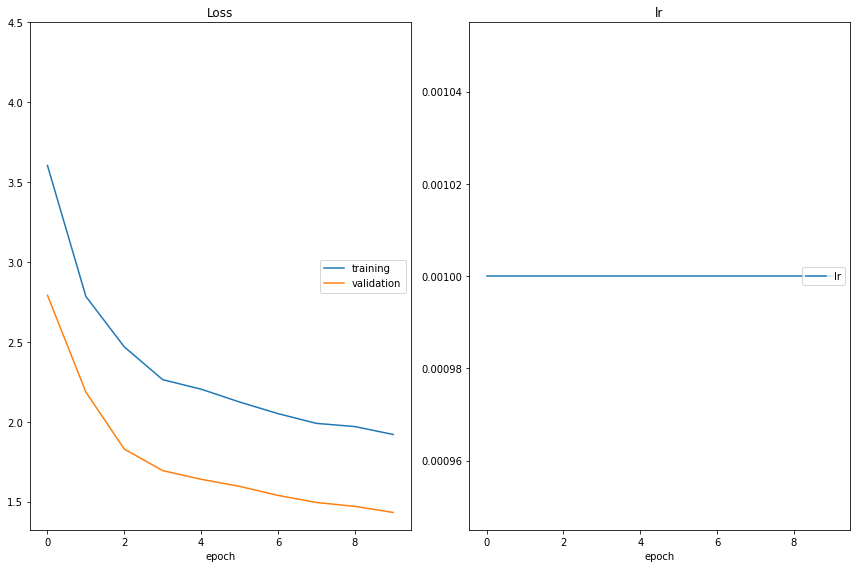

In [ ]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning

# Get a model using get_model_transfer_learning
model_transfer = get_model_transfer_learning(model_name="resnet50", n_classes=num_classes)

# train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoint/model_transfer.pt",
    interactive_tracking=True
)

### Model notes

- Input size: 224 × 224 × 3 (standard for ResNet).
- Backbone: ResNet-50 (50 layers, residual connections), ImageNet pre-training gives the model strong low-level and mid-level features that are transferable to landmark recognition.

- Classifier head: Two linear layers with dropout and ReLU for regularization.
- The original ResNet-50 classifier has 1000 ImageNet classes. We replace it with a small MLP (2048 → 512 → 50) to match our 50 landmark classes. Adding dropout (0.5 and 0.3) and an intermediate layer helps the model generalize better on our relatively small dataset. 

### 3: Testing the Model

In [8]:
import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning("resnet50", n_classes=num_classes)
# Load saved weights
model_transfer.load_state_dict(torch.load('checkpoint/model_transfer.pt'))

one_epoch_test(data_loaders['test'], model_transfer, loss)

Testing: 100%|██████████████████████████████████| 20/20 [00:15<00:00,  1.28it/s]

Test Loss: 1.252667


Test Accuracy: 66% (828/1250)


1.2526672273874282

### 4: Export the model

In [ ]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model_transfer = model_transfer.cpu()
model_transfer.load_state_dict(
    torch.load("checkpoint/model_transfer.pt", map_location="cpu")
)

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoint/transfer_exported.pt")

Reusing cached mean and std


100%|███████████████████████████████████████| 1250/1250 [08:10<00:00,  2.55it/s]


Accuracy: 0.6568


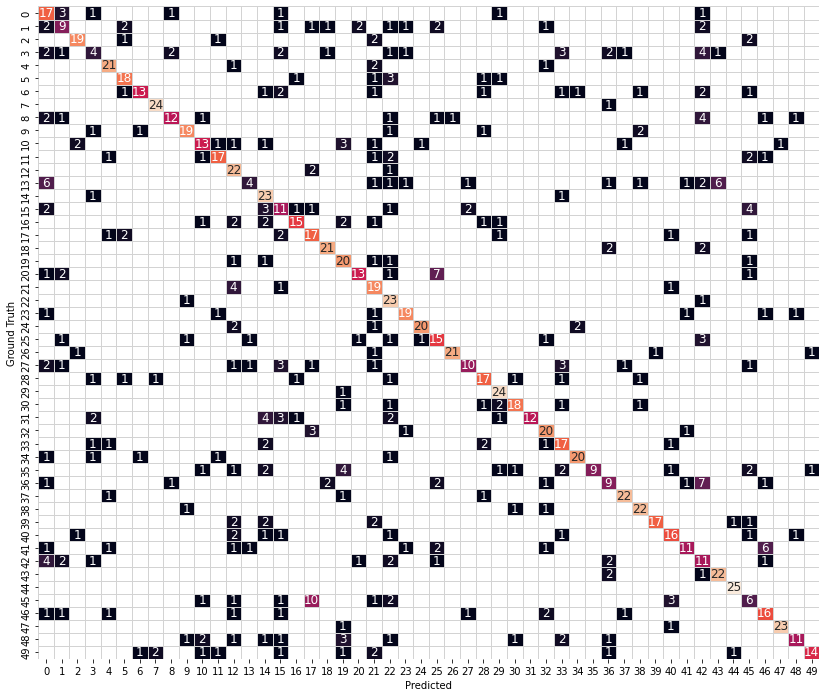

In [10]:
import torch
from src.predictor import predictor_test
from src.helpers import plot_confusion_matrix

model_reloaded = torch.jit.load("checkpoint/transfer_exported.pt")

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

plot_confusion_matrix(pred, truth)